# Libraries Import

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from PIL.ImImagePlugin import split
from pandas.core.common import random_state

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, InputLayer, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import models

import kagglehub
import pickle

# Dataset Download

In [2]:

# Download latest version
datasetPath = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", datasetPath)

Path to dataset files: C:\Users\a24e4\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1


# Dataset Import

In [3]:
def load_data(path):
    x_data = []
    y_data = []
    for class_name in os.listdir(path):
        for img_name in os.listdir(os.path.join(path, class_name)):
            im = cv2.imread(os.path.join(path, class_name, img_name))
            
            #resize image
            im = cv2.resize(im, (224, 224))
            
            x_data.append(im)
            y_data.append(class_name.lower())
            
            print("Loaded:", os.path.join(path, class_name, img_name))
            
    return x_data, y_data

In [4]:
x_train, y_train = load_data(os.path.join(datasetPath, "Training"))
x_test, y_test = load_data(os.path.join(datasetPath, "Testing"))

Loaded: C:\Users\a24e4\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1\Training\glioma\Tr-glTr_0000.jpg
Loaded: C:\Users\a24e4\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1\Training\glioma\Tr-glTr_0001.jpg
Loaded: C:\Users\a24e4\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1\Training\glioma\Tr-glTr_0002.jpg
Loaded: C:\Users\a24e4\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1\Training\glioma\Tr-glTr_0003.jpg
Loaded: C:\Users\a24e4\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1\Training\glioma\Tr-glTr_0004.jpg
Loaded: C:\Users\a24e4\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1\Training\glioma\Tr-glTr_0005.jpg
Loaded: C:\Users\a24e4\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1\Training\glioma\Tr-glTr_0006.jpg
Loaded: C:\Users\a24e4\.cache\kagglehub\datasets\masoudnickpar

In [5]:
x_train = np.array(x_train)
y_train =np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# Data Exploration

In [6]:
print('x_train size:', x_train.shape)
print('y_train size:', y_train.shape)
print('x_test size:', x_test.shape)
print('y_test size:', y_test.shape)

x_train size: (5712, 224, 224, 3)
y_train size: (5712,)
x_test size: (1311, 224, 224, 3)
y_test size: (1311,)


In [7]:
classes_str = np.unique(y_train)

In [8]:
classes_str

array(['glioma', 'meningioma', 'notumor', 'pituitary'], dtype='<U10')

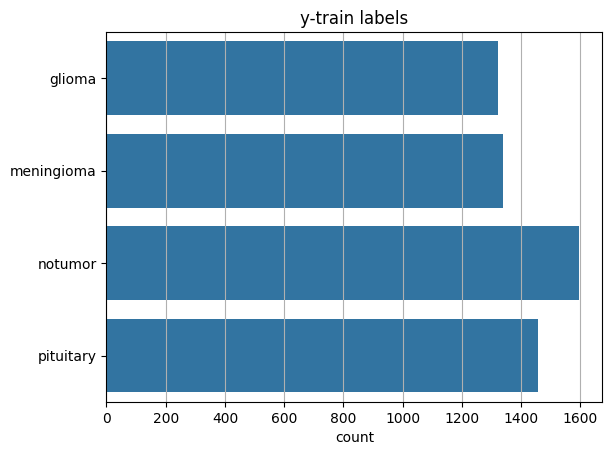

In [9]:
plt.title("y-train labels")
plt.grid(True)
sns.countplot(y_train)
plt.style.use(plt.style.available[11])
plt.show()

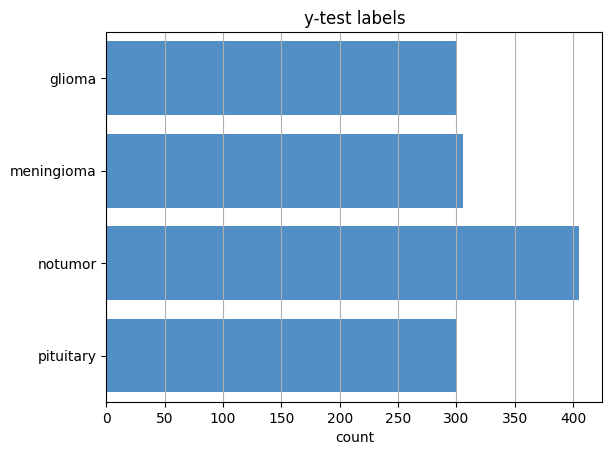

In [10]:
plt.title("y-test labels")
plt.grid(True)
sns.countplot(y_test)
plt.style.use(plt.style.available[11])
plt.show()

# Image Presentation

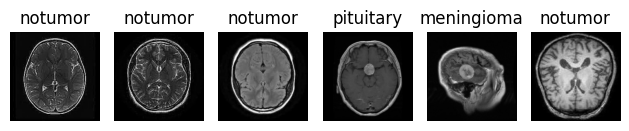

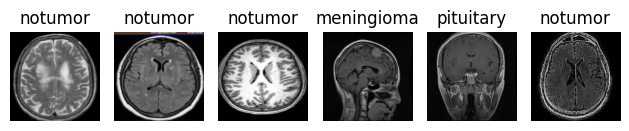

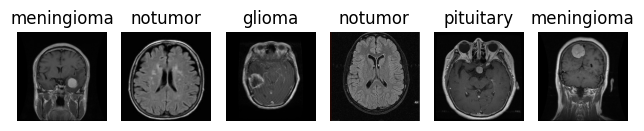

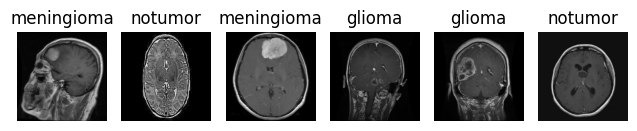

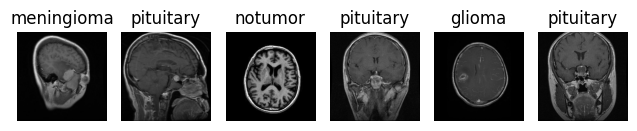

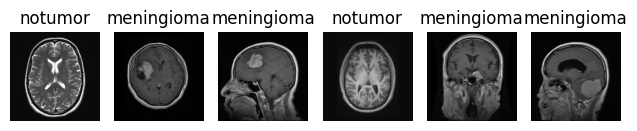

In [11]:
n_item_per_row = 6
n_rows = 6

for i in range(n_rows):
    for j in range(n_item_per_row):
        im_index = np.random.randint(0, x_train.shape[0])
        plt.tight_layout()
        
        plt.subplot(1, n_item_per_row, j + 1)
        plt.imshow(x_train[im_index])
        plt.title(y_train[im_index])
        plt.axis('off')
    plt.show()

# Image Augmentation

In [12]:
def augment_flip(image):
    if np.random.rand() > 0.5:
        image = cv2.flip(image, 1)

    return image

In [13]:
def augment_rotate(image):
    angle = np.random.randint(-30, 31)
    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    image = cv2.warpAffine(image, M, (width, height))
    return image

In [14]:
def augment_shift(image):
    height, width = image.shape[:2]
    tx = 0.1 * np.sin(np.random.randint(0, 2 * np.pi)) * width
    ty = 0.1 * np.sin(np.random.randint(0, 2 * np.pi)) * height
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    image = cv2.warpAffine(image, M, (width, height))
    return image

In [15]:
def image_augmentation(image_array, labels, n_episode):
    augmented_images = []
    augmented_image_labels = []

    n_images = len(image_array)
    for episode in range(n_episode):
        for i in range(n_images):
            im = image_array[i].copy()
            im = augment_flip(im)
            im = augment_rotate(im)
            im = augment_shift(im)
            
            augmented_images.append(im)
            augmented_image_labels.append(labels[i])           
    return np.array(augmented_images), np.array(augmented_image_labels)


In [16]:
x_train_aug, y_train_aug = image_augmentation(x_train, y_train, 4)
x_test_aug, y_test_aug = image_augmentation(x_test, y_test, 2)

In [17]:
print('x_train_aug size:', x_train_aug.shape)
print('y_train_aug size:', y_train_aug.shape)
print('x_test_aug size: ', x_test_aug.shape)
print('y_test_aug size: ', y_test.shape)

x_train_aug size: (22848, 224, 224, 3)
y_train_aug size: (22848,)
x_test_aug size:  (2622, 224, 224, 3)
y_test_aug size:  (1311,)


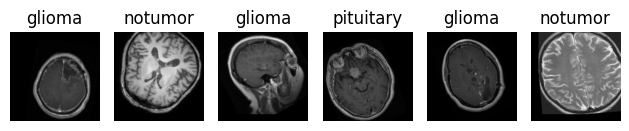

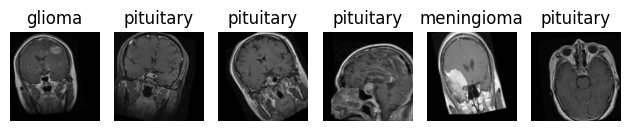

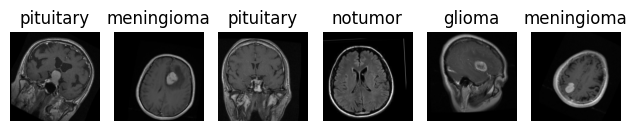

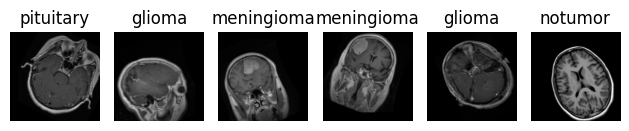

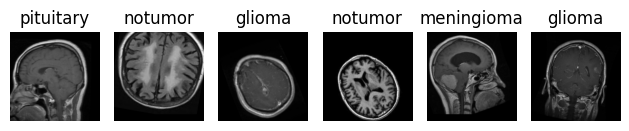

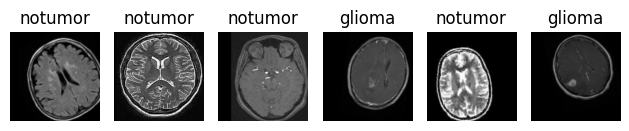

In [18]:
n_item_per_row = 6
n_rows = 6

for i in range(n_rows):
    for j in range(n_item_per_row):
        im_index = np.random.randint(0, x_train_aug.shape[0])
        plt.tight_layout()
        plt.subplot(1, n_item_per_row, j + 1)
        plt.imshow(x_train_aug[im_index])
        plt.title(y_train_aug[im_index])
        plt.axis('off')
    plt.show()

In [19]:
x_train = np.concatenate((x_train, x_train_aug), axis=0)
x_test = np.concatenate((x_test, x_test_aug), axis=0)

y_train = np.concatenate((y_train, y_train_aug), axis=0)
y_test = np.concatenate((y_test, y_test_aug), axis=0)

In [20]:
del x_train_aug, y_train_aug, x_test_aug, y_test_aug

# Images Preparation for training

In [21]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

LabelEncoder()

In [22]:
y_train = np.array(label_encoder.transform(y_train))
y_test = np.array(label_encoder.transform(y_test))

In [23]:
print("Test Samples: ", y_train[ np.random.choice(y_train.shape[0], 10) ])

Test Samples:  [0 2 1 0 1 1 1 3 0 1]


In [24]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [25]:
print("Test Samples: \n", y_train[ np.random.choice(y_train.shape[0], 10) ])

Test Samples: 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


In [26]:
labels = {idx: label for idx, label in enumerate(label_encoder.classes_)}
pickle.dump(labels, open('labels.pkl', 'wb'))

In [27]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [28]:
print('x_train size:', x_train.shape)
print('y_train size:', y_train.shape)
print('x_test size: ', x_test.shape)
print('y_test size: ', y_test.shape)

x_train size: (28560, 224, 224, 3)
y_train size: (28560, 4)
x_test size:  (3933, 224, 224, 3)
y_test size:  (3933, 4)


# CNN-Model Architecture

In [29]:
cnn_model = Sequential()

cnn_model.add(InputLayer(shape=x_train.shape[1:]))

cnn_model.add(Conv2D(64, (3, 3), padding='same'))
cnn_model.add(Conv2D(64, (3, 3), padding='same'))
cnn_model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
cnn_model.add(Flatten())

cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dense(len(classes_str), activation='softmax'))

In [30]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 112, 112, 64)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 802816)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │   102,760,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,809,764 (392.19 MB)

 Trainable params: 102,809,764 (392.19 MB)

 Non-trainable params: 0 (0.00 B)

# Early Stopping & Reduce Learning Rate

In [31]:
early_stopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

learning_rate_reduction = (
    ReduceLROnPlateau(
        monitor='val_accuracy',
        patience=2,
        factor=0.5,
        min_lr=0.00001))


In [32]:
checkpoint = ModelCheckpoint(
    'best_model_1.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
)

# Model Compilation & Training

In [33]:
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
if os.path.isfile('best_model_1.keras'):
    cnn_model = models.load_model('best_model_1.keras')

In [35]:
history = cnn_model.fit(
    x_train, y_train,
    batch_size=128,
    epochs=10,
    validation_split=0.2,
    callbacks=[learning_rate_reduction, early_stopping, checkpoint]
)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1583s 8s/step - accuracy: 0.6736 - loss: 0.8357 - val_accuracy: 0.6616 - val_loss: 0.8542 - learning_rate: 0.0010
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1502s 8s/step - accuracy: 0.7276 - loss: 0.7059 - val_accuracy: 0.6430 - val_loss: 0.8986 - learning_rate: 0.0010
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1486s 8s/step - accuracy: 0.7715 - loss: 0.6047 - val_accuracy: 0.6539 - val_loss: 0.9338 - learning_rate: 0.0010
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1478s 8s/step - accuracy: 0.8403 - loss: 0.4434 - val_accuracy: 0.6593 - val_loss: 0.8923 - learning_rate: 5.0000e-04
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1479s 8s/step - accuracy: 0.8824 - loss: 0.3364 - val_accuracy: 0.6462 - val_loss: 0.9827 - learning_rate: 5.0000e-04
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1453s 8s/step - accuracy: 0.9365 - loss: 0.2190 - val_accuracy: 0.6499 - val_loss: 1.0587 - learning_rate: 2.5000e-04
Epoch 6: early stopping


# Training History

In [36]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


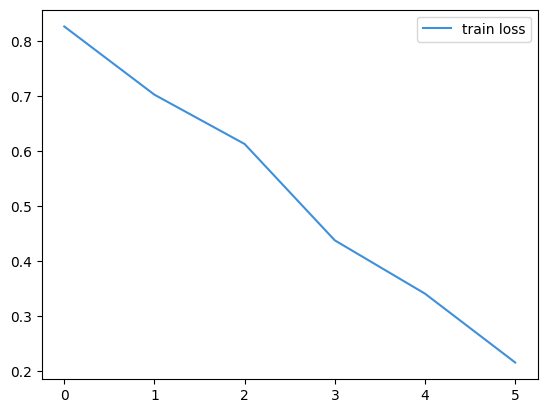

In [37]:
plt.style.use(plt.style.available[11])

plt.plot(history.history['loss'], label='train loss')

plt.legend()
plt.show()

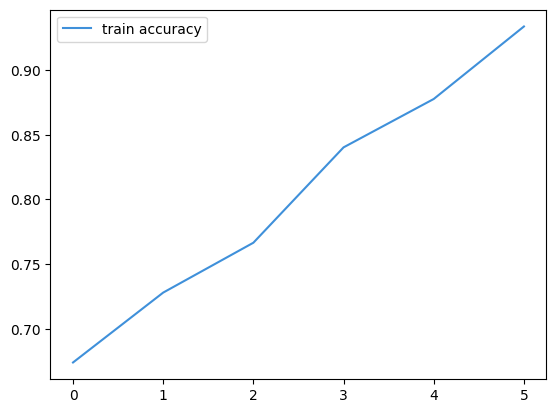

In [38]:
plt.style.use(plt.style.available[11])

plt.plot(history.history['accuracy'], label='train accuracy')

plt.legend()
plt.show()

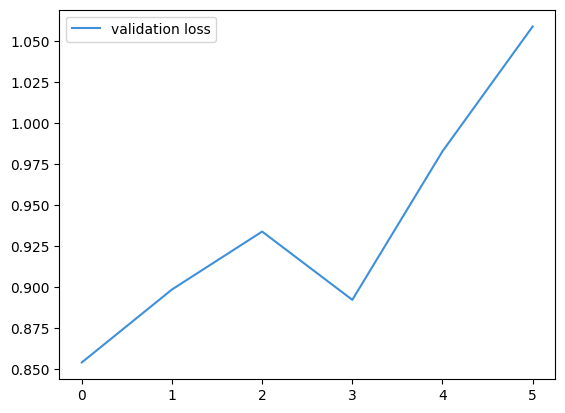

In [39]:
plt.style.use(plt.style.available[11])

plt.plot(history.history['val_loss'], label='validation loss')

plt.legend()
plt.show()

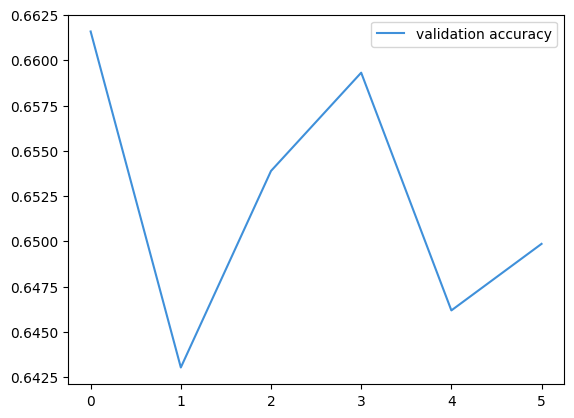

In [40]:
plt.style.use(plt.style.available[11])

plt.plot(history.history['val_accuracy'], label='validation accuracy')

plt.legend()
plt.show()


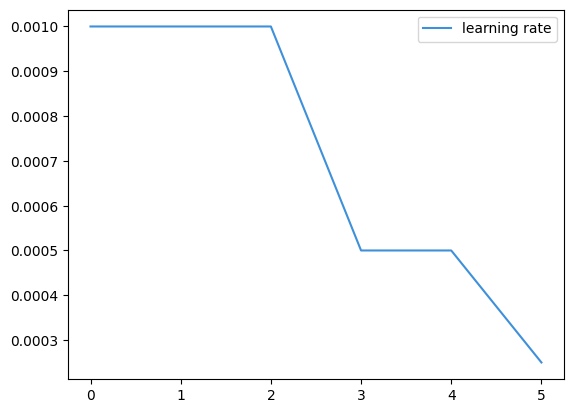

In [41]:
plt.style.use(plt.style.available[11])

plt.plot(history.history['learning_rate'], label='learning rate')

plt.legend()
plt.show()

# Model Evaluation

In [42]:
y_predict_encoded = cnn_model.predict(x_test)

123/123 ━━━━━━━━━━━━━━━━━━━━ 39s 293ms/step


In [43]:
_y_predict_ = [list(i).index(max(i)) for i in y_predict_encoded]
_y_test_ = [list(i).index(max(i)) for i in y_test]

print("Accuracy: ", metrics.accuracy_score(_y_test_, _y_predict_))

Accuracy:  0.6953979150775489


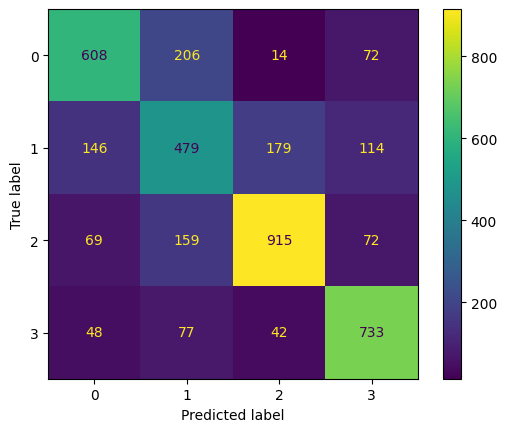

In [44]:
metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(_y_test_, _y_predict_)
).plot()

In [45]:
# pickle.dump(cnn_model, open('model_1.pkl', 'wb'))

# Pretrained model VGG16

In [46]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(len(classes_str), activation='softmax')(x)

vgg16_model = Model(inputs=base_model.input, outputs=x)

for layer in base_model.layers:
    layer.trainable = False


In [47]:
vgg16_model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,244,100 (58.15 MB)

 Trainable params: 529,412 (2.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [48]:
vgg16_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [49]:
early_stopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

learning_rate_reduction = (
    ReduceLROnPlateau(
        monitor='val_accuracy',
        patience=5,
        factor=0.5,
        min_lr=0.00001))

checkpoint = ModelCheckpoint(
    'best_model_2.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
)


In [50]:
if os.path.isfile('best_model_2.keras'):
    vgg16_model = models.load_model('best_model_2.keras')

In [51]:
history = vgg16_model.fit(
    x_train, y_train,
    epochs=10,
    callbacks=[early_stopping, learning_rate_reduction, checkpoint],
    validation_split=0.2
)

Epoch 1/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 1838s 3s/step - accuracy: 0.8934 - loss: 0.1420 - val_accuracy: 0.9067 - val_loss: 0.1264 - learning_rate: 0.0010
Epoch 2/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 1826s 3s/step - accuracy: 0.9108 - loss: 0.1210 - val_accuracy: 0.9100 - val_loss: 0.1232 - learning_rate: 0.0010
Epoch 3/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 1825s 3s/step - accuracy: 0.9172 - loss: 0.1099 - val_accuracy: 0.9280 - val_loss: 0.1023 - learning_rate: 0.0010
Epoch 4/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 1825s 3s/step - accuracy: 0.9244 - loss: 0.1012 - val_accuracy: 0.9209 - val_loss: 0.1036 - learning_rate: 0.0010
Epoch 5/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 1826s 3s/step - accuracy: 0.9323 - loss: 0.0903 - val_accuracy: 0.9379 - val_loss: 0.0842 - learning_rate: 0.0010
Epoch 6/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 1823s 3s/step - accuracy: 0.9395 - loss: 0.0848 - val_accuracy: 0.9375 - val_loss: 0.0809 - learning_rate: 0.0010
Epoch 7/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 1849s 3s/step - accuracy: 0.9386 - l

In [52]:
y_predict_encoded = vgg16_model.predict(x_test)

_y_predict_ = [list(i).index(max(i)) for i in y_predict_encoded]
_y_test_ = [list(i).index(max(i)) for i in y_test]

print("Accuracy", metrics.accuracy_score(_y_test_, _y_predict_))

123/123 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step
Accuracy 0.92372234935164


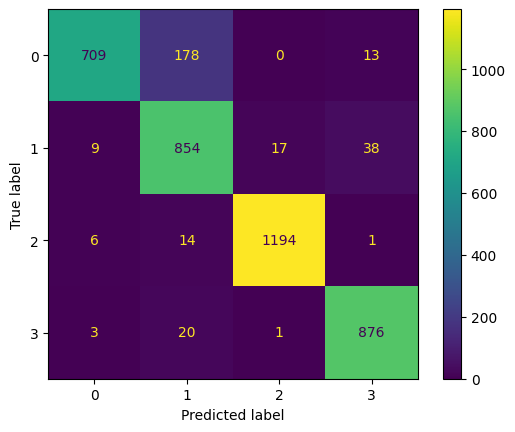

In [53]:
metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(_y_test_, _y_predict_)
).plot() 

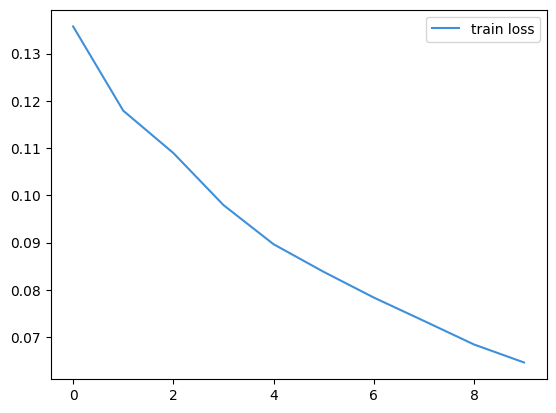

In [54]:
plt.style.use(plt.style.available[11])

plt.plot(history.history['loss'], label='train loss')

plt.legend()
plt.show()

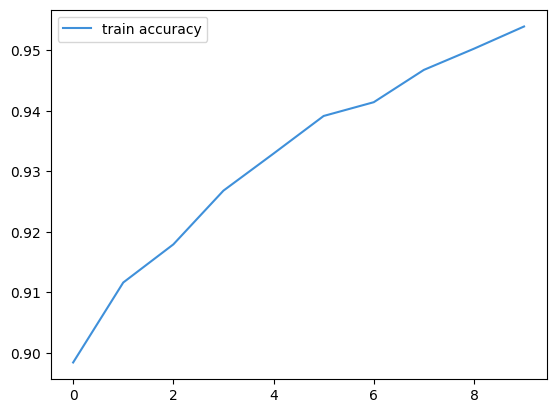

In [55]:
plt.style.use(plt.style.available[11])

plt.plot(history.history['accuracy'], label='train accuracy')

plt.legend()
plt.show()

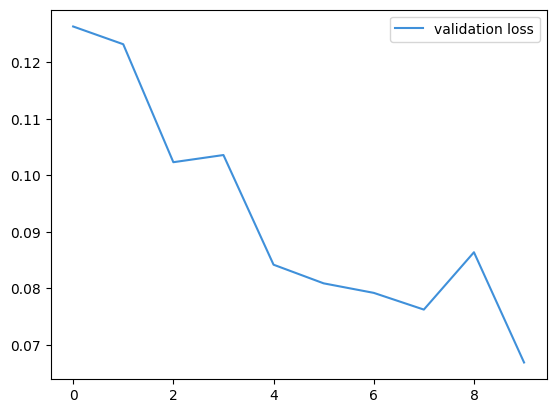

In [56]:
plt.style.use(plt.style.available[11])

plt.plot(history.history['val_loss'], label='validation loss')

plt.legend()
plt.show()

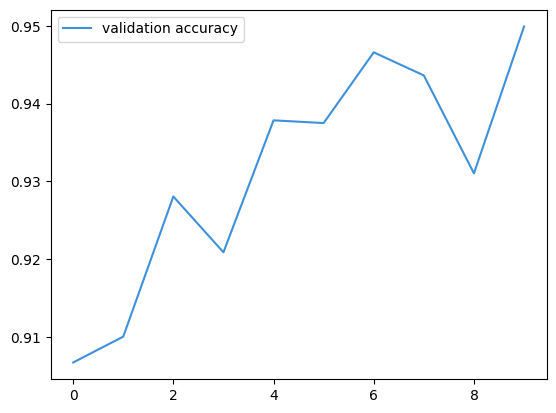

In [57]:
plt.style.use(plt.style.available[11])

plt.plot(history.history['val_accuracy'], label='validation accuracy')

plt.legend()
plt.show()

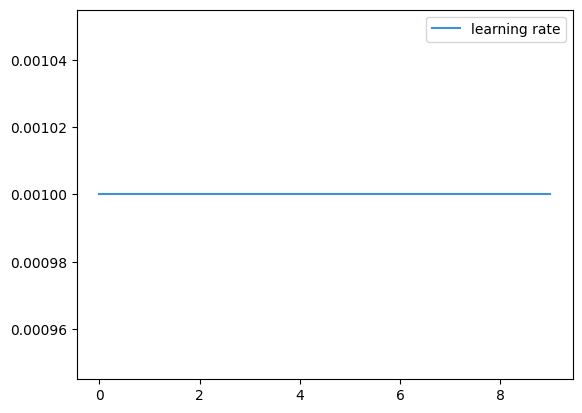

In [58]:
plt.style.use(plt.style.available[11])

plt.plot(history.history['learning_rate'], label='learning rate')

plt.legend()
plt.show()

In [59]:
# pickle.dump(vgg16_model, open('model_2.pkl', 'wb'))

# Pretrained Model ResNet50

In [60]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(len(classes_str), activation='softmax')(x)

resnet50_model = Model(inputs=base_model.input, outputs=x)

for layer in base_model.layers:
    layer.trainable = False


In [61]:
resnet50_model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,689,988 (98.00 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [62]:
resnet50_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [63]:
early_stopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

learning_rate_reduction = (
    ReduceLROnPlateau(
        monitor='val_accuracy',
        patience=2,
        factor=0.5,
        min_lr=0.00001))

checkpoint = ModelCheckpoint(
    'best_model_3.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
)


In [64]:
if os.path.isfile('best_model_3.keras'):
    vgg16_model = models.load_model('best_model_3.keras')

In [65]:
history = resnet50_model.fit(
    x_train, y_train,
    epochs=10,
    callbacks=[early_stopping, learning_rate_reduction, checkpoint],
    validation_split=0.2
)

Epoch 1/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 806s 1s/step - accuracy: 0.5110 - loss: 1.1137 - val_accuracy: 0.5513 - val_loss: 1.0229 - learning_rate: 0.0010
Epoch 2/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 777s 1s/step - accuracy: 0.6356 - loss: 0.8765 - val_accuracy: 0.6565 - val_loss: 0.8192 - learning_rate: 0.0010
Epoch 3/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 771s 1s/step - accuracy: 0.6670 - loss: 0.8053 - val_accuracy: 0.6176 - val_loss: 0.8600 - learning_rate: 0.0010
Epoch 4/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 792s 1s/step - accuracy: 0.6807 - loss: 0.7620 - val_accuracy: 0.6807 - val_loss: 0.7869 - learning_rate: 0.0010
Epoch 5/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 779s 1s/step - accuracy: 0.6909 - loss: 0.7412 - val_accuracy: 0.6576 - val_loss: 0.8348 - learning_rate: 0.0010
Epoch 6/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 782s 1s/step - accuracy: 0.7119 - loss: 0.7131 - val_accuracy: 0.6786 - val_loss: 0.7732 - learning_rate: 0.0010
Epoch 7/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 791s 1s/step - accuracy: 0.7266 - loss: 0.

KeyboardInterrupt: 

In [66]:
y_predict_encoded = resnet50_model.predict(x_test)

_y_predict_ = [list(i).index(max(i)) for i in y_predict_encoded]
_y_test_ = [list(i).index(max(i)) for i in y_test]

print("Accuracy", metrics.accuracy_score(_y_test_, _y_predict_))

123/123 ━━━━━━━━━━━━━━━━━━━━ 113s 896ms/step
Accuracy 0.6816679379608441


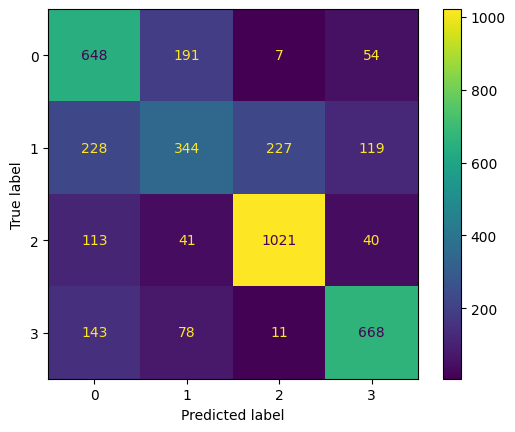

In [67]:
metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(_y_test_, _y_predict_)
).plot() 

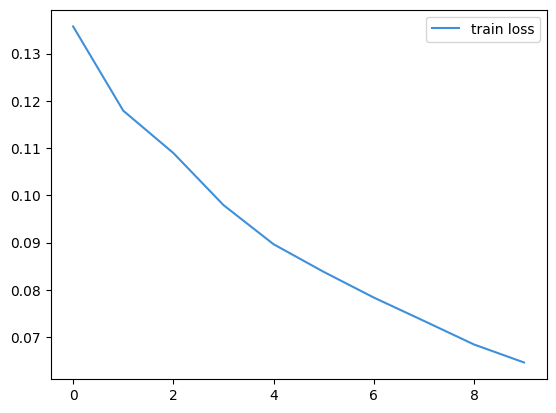

In [68]:
plt.style.use(plt.style.available[11])

plt.plot(history.history['loss'], label='train loss')

plt.legend()
plt.show()

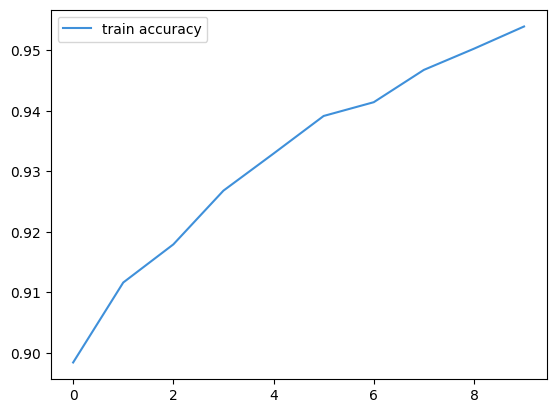

In [69]:
plt.style.use(plt.style.available[11])

plt.plot(history.history['accuracy'], label='train accuracy')

plt.legend()
plt.show()

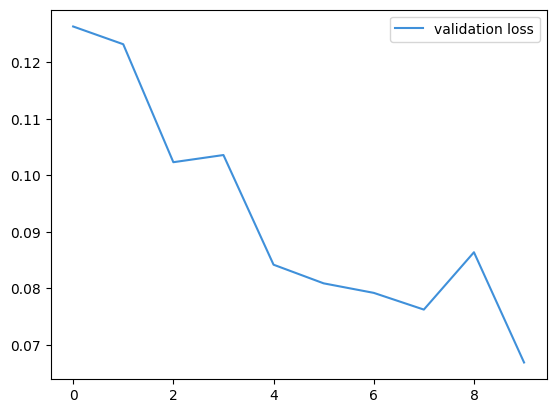

In [70]:
plt.style.use(plt.style.available[11])

plt.plot(history.history['val_loss'], label='validation loss')

plt.legend()
plt.show()

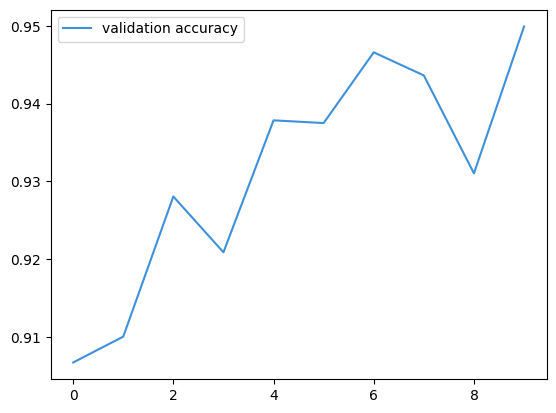

In [71]:
plt.style.use(plt.style.available[11])

plt.plot(history.history['val_accuracy'], label='validation accuracy')

plt.legend()
plt.show()

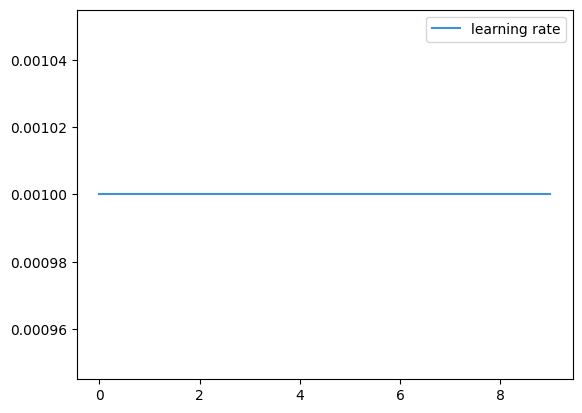

In [72]:
plt.style.use(plt.style.available[11])

plt.plot(history.history['learning_rate'], label='learning rate')

plt.legend()
plt.show()

In [73]:
# pickle.dump(resnet50_model, open('model_3.pkl', 'wb'))

# Voting, Ensemble technique

In [ ]:
pred_1 = cnn_model.predict(x_test)
pred_2 = vgg16_model.predict(x_test)
pred_3 = resnet50_model.predict(x_test)

123/123 ━━━━━━━━━━━━━━━━━━━━ 40s 309ms/step


In [ ]:
voting_propa = np.mean([pred_1, pred_2, pred_3], axis=0)
voting_predict = np.argmax(voting_propa, axis = 1)

In [ ]:
print("Accuracy", metrics.accuracy_score(_y_test_, voting_predict))

In [ ]:
metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(_y_test_, voting_predict)
).plot() 